In [110]:
from make_ewma_features_df import *
from useful_funcs import *
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# Fitting model

In [2]:
gw_df = get_dfs(25, 38)
ewma_merge_lag = make_ewma_features_df(gw_df, 25, 0.4).dropna()

In [3]:
model_dict = {}
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    ewma_merge_lag_pos = ewma_merge_lag.query('position==@pos').set_index(['full_name', 'gw'])
    X = ewma_merge_lag_pos[[
        'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
        'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
        'minutes', 'ewma_total_points', 'ewma_team_goals',
        'ewma_nw_opponent_goals']]

    y = ewma_merge_lag_pos['nw_total_points']

    model = LinearRegression()
    model.fit(X, y)

    model_dict[pos] = model

# Testing on last season

In [4]:
pred_dfs = []
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    gw5_pos = ewma_merge_lag.query('gw==5 and position==@pos').set_index(['full_name', 'gw'])

    pos_pred = model_dict[pos].predict(gw5_pos[['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
        'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
        'minutes', 'ewma_total_points', 'ewma_team_goals',
        'ewma_nw_opponent_goals']])

    gw5_pos['pred'] = pos_pred
    pred_dfs.append(gw5_pos)
    
pred_df = pd.concat(pred_dfs)


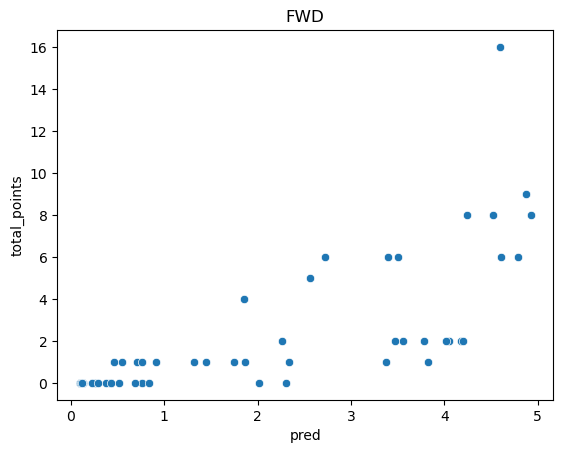

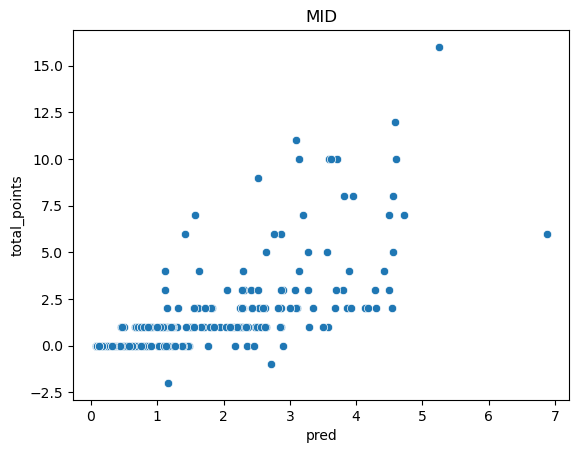

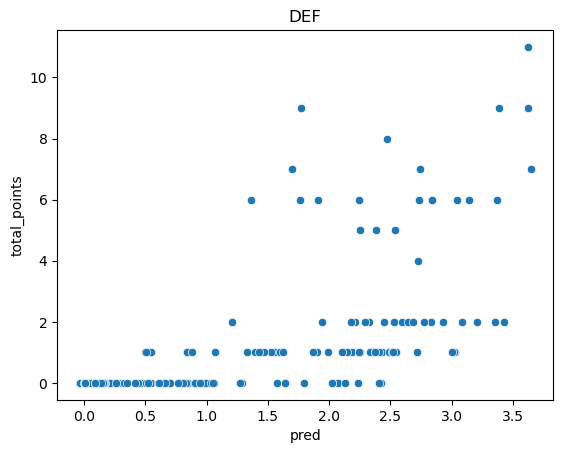

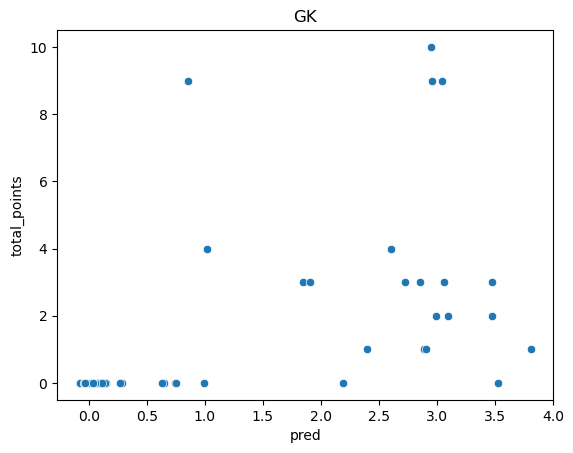

In [5]:
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    plt.figure()
    sns.scatterplot(data=pred_df.query('position==@pos'), y='total_points', x='pred').set(title=pos)

# Applying to this season's data

In [6]:
import requests, json

In [7]:
# gw_dfs = []

# for gw in range(38):
#     event_id = gw + 1
#     url = f'https://fantasy.premierleague.com/api/event/{event_id}/live/'
#     response = requests.get(url)
#     if response.status_code != 200:
#         raise Exception("Response was code " + str(response.status_code))
#     gw1 = json.loads(response.text)

#     # Ensure each 'stats' is a list
#     elements = gw1['elements']
#     for el in elements:
#         if isinstance(el.get('stats'), dict):
#             el['stats'] = [el['stats']]

#     gw_df = pd.json_normalize(
#         elements,
#         record_path=['stats'],
#         meta=['id', 'explain', 'modified']
#     )

#     gw_df['gw'] = event_id
#     gw_dfs.append(gw_df)

# gw_all = pd.concat(gw_dfs).reset_index(drop=True)

## Trying to do it myself

In [14]:
gw_df = get_dfs(26, 4)

In [61]:
alpha = 0.4

gw_df = get_dfs(26, 4)
gw_df = add_goals(gw_df)
gw_df = clean_name_in_index(gw_df)

player_value_cols = ['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored',
                    'influence', 'creativity', 'threat', 'ict_index', 'minutes', 'total_points']
merge_cols_players = ['full_name', 'gw', 'total_points', 'position','team','opponent_team']
ewma_gw_df_players = ewma(gw_df, 'full_name', player_value_cols, alpha, {'total_points': 'ewma_total_points'}, merge_cols_players)

gw_df_teams = get_teams_df(gw_df)
team_value_cols = ['team_goals']
merge_cols_teams = ['team', 'gw']
ewma_gw_df_teams = ewma(gw_df_teams, 'team', team_value_cols, alpha, {'team_goals': 'ewma_team_goals'}, merge_cols_teams)

In [67]:
teamcode_dict = get_teamcodes(26)
ewma_gw_df_opponent_team = ewma_gw_df_teams.rename(columns={'team': 'opponent_team_name', 
                                                            'ewma_team_goals': 'ewma_nw_opponent_goals'})
ewma_gw_df = ewma_gw_df_players.merge(ewma_gw_df_teams, on=['team', 'gw'], how='left')

In [68]:
league_url = 'https://fantasy.premierleague.com/api/fixtures/'
r = requests.get(league_url).json()

fixtures_df = pd.json_normalize(r)

In [74]:
fixtures_df_gw = fixtures_df.query('event==4+1')

h_teams = fixtures_df_gw['team_h'].map(teamcode_dict)
a_teams = fixtures_df_gw['team_a'].map(teamcode_dict)
fixture_dict = {**dict(zip(h_teams, a_teams)), **dict(zip(a_teams, h_teams))}

In [75]:
ewma_gw_df['nw_opponent_team_name'] = ewma_gw_df_players['team'].map(fixture_dict)

In [83]:
team_goal_dict = dict(
    zip(ewma_gw_df_teams.query('gw==4')['team'], ewma_gw_df_teams.query('gw==4')['ewma_team_goals']))

In [86]:
ewma_gw_df['ewma_nw_opponent_goals'] = ewma_gw_df['nw_opponent_team_name'].map(team_goal_dict)

In [90]:
ewma_gw_df_gw = ewma_gw_df.query('gw==4')

In [ ]:
ewma_gw_df_gw

,full_name,gw,total_points,position,team,opponent_team,assists,bonus,bps,clean_sheets,...,influence,creativity,threat,ict_index,minutes,ewma_total_points,opponent_team_name,ewma_team_goals,nw_opponent_team_name,ewma_nw_opponent_goals
3,aaron_anselmino,4,0,DEF,Chelsea,5,0.0,0.0,0.000,0.0,...,0.0000,0.0000,0.000,0.0000,0.000,0.000,Man Utd,2.000,Man Utd,0.864
7,aaron_hickey,4,1,DEF,Brentford,7,0.0,0.0,0.536,0.0,...,1.0880,0.1344,0.000,0.1408,4.816,0.544,Fulham,1.400,Fulham,0.760
11,aaron_ramsdale,4,0,GK,Newcastle,20,0.0,0.0,0.000,0.0,...,0.0000,0.0000,0.000,0.0000,0.000,0.000,Bournemouth,0.688,Bournemouth,1.616
15,aaron_ramsey,4,0,MID,Burnley,12,0.0,0.0,0.000,0.0,...,0.0000,0.0000,0.000,0.0000,0.000,0.000,Nott'm Forest,0.768,Nott'm Forest,0.792
19,aaron_wan_bissaka,4,0,DEF,West Ham,18,0.0,0.0,0.792,0.0,...,6.2928,8.1864,1.728,1.6344,32.400,0.216,Crystal Palace,0.864,Crystal Palace,0.864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,zain_silcott_duberry,4,0,MID,Bournemouth,6,0.0,0.0,0.000,0.0,...,0.0000,0.0000,0.000,0.0000,0.000,0.000,Newcastle,1.616,Newcastle,0.688
2834,zak_johnson,4,0,DEF,Sunderland,8,0.0,0.0,0.000,0.0,...,0.0000,0.0000,0.000,0.0000,0.000,0.000,Aston Villa,1.128,Aston Villa,0.000
2838,zeki_amdouni,4,0,FWD,Burnley,12,0.0,0.0,0.000,0.0,...,0.0000,0.0000,0.000,0.0000,0.000,0.000,Nott'm Forest,0.768,Nott'm Forest,0.792
2842,zepiqueno_redmond,4,0,FWD,Aston Villa,9,0.0,0.0,0.000,0.0,...,0.0000,0.0000,0.000,0.0000,0.000,0.000,Sunderland,0.000,Sunderland,1.128


In [ ]:
pred_dfs = []
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    gw_pos = ewma_gw_df.query('gw==4 and position==@pos').set_index(['full_name', 'gw'])

    pos_pred = model_dict[pos].predict(gw_pos[['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
        'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
        'minutes', 'ewma_total_points', 'ewma_team_goals',
        'ewma_nw_opponent_goals']])

    gw_pos['pred'] = pos_pred
    pred_dfs.append(gw_pos)
    
pred_df = pd.concat(pred_dfs)

In [107]:
league_url = 'https://draft.premierleague.com/api/league/19188/element-status'
r = requests.get(league_url).json()
ownership_df = pd.json_normalize(r['element_status'])

In [126]:
url = 'https://draft.premierleague.com/api/bootstrap-static'
req = requests.get(url).json()
players_df = pd.json_normalize(req['elements'])

players_df['full_name'] = players_df['first_name'] + ' ' + players_df['second_name']
players_df = clean_name_in_index(players_df.set_index('full_name'))

merge_name_df = players_df[['id', 'full_name']]

In [131]:
ownership_df_name = ownership_df.merge(merge_name_df, how='left', left_on='element', right_on='id')
ownership_df_to_merge = ownership_df_name[['full_name', 'owner']]

In [138]:
pred_df_owners = pred_df.merge(ownership_df_to_merge, on='full_name')

In [155]:
pred_df_simple = pred_df_owners[['full_name', 'ewma_total_points', 'position', 'pred', 'owner']]

In [156]:
pred_df_simple_sorted = pred_df_simple.sort_values(by='pred', ascending=False)

In [157]:
pred_df_simple_sorted.head(50)

,full_name,ewma_total_points,position,pred,owner
23,erling_haaland,10.456,FWD,5.508125,88376.0
125,bryan_mbeumo,3.920,MID,4.945250,93330.0
174,enzo_fernandez,6.568,MID,4.944126,87737.0
53,nick_woltemade,9.000,FWD,4.785677,93330.0
104,antoine_semenyo,9.784,MID,4.763469,87737.0
71,viktor_gyokeres,4.584,FWD,4.745649,88376.0
141,cody_gakpo,4.872,MID,4.659935,85076.0
213,iliman_ndiaye,5.264,MID,4.622468,NaN
321,mohamed_salah,6.768,MID,4.607180,93330.0
29,hugo_ekitike,4.952,FWD,4.498236,85076.0


In [162]:
pred_df_simple_sorted.query('full_name=="phil_foden"').sort_values('pred', ascending=False).head(50)

,full_name,ewma_total_points,position,pred,owner
343,phil_foden,4.944,MID,2.773186,88376.0
